# STAT4012 Group Project
- The file is used to test the code for the project.  
- It should be written with **clear comments** and **explanations** on each sections of the code.  
- If there are some other modules that need to be imported or run in this file, you can use %load filename.py to load the code from the file. use %run filename.py to run the code from the file.  

In [1]:
# import libraries
# all the libraries are imported here but not below
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_excel('../data/raw_data_adjusted.xlsx',
                     index_col=0).dropna(how='any')
data.sort_values(by='date', ascending=True, inplace=True)

## 1.Preprocessing

### 1.1 calculate 6th day's intraday return -> label

In [3]:

data['return'] = data['close'].pct_change(6).shift(-6)
print(data)


                open     close      high       low  daily_trading_value  \
date                                                                      
2017-11-28   21.0907   21.1700   21.3333   20.9280           1571825024   
2017-11-29   21.1533   20.5027   21.2000   20.0820           2704045056   
2017-11-30   20.5707   20.5900   20.7133   20.3027           1340292992   
2017-12-01   20.3627   20.4353   20.6880   20.3367           1318467968   
2017-12-04   20.4333   20.3467   20.5510   20.0407           1779769984   
...              ...       ...       ...       ...                  ...   
2023-04-06  183.0800  185.0600  186.3900  179.7400          22769979392   
2023-04-10  179.9400  184.5100  185.1000  176.1100          25713080320   
2023-04-11  186.6900  186.7900  189.1900  185.6475          21636679680   
2023-04-12  190.7400  180.5400  191.5846  180.3100          27686340608   
2023-04-13  182.9550  185.9000  186.5000  180.9400          20838680576   

            daily_tradin

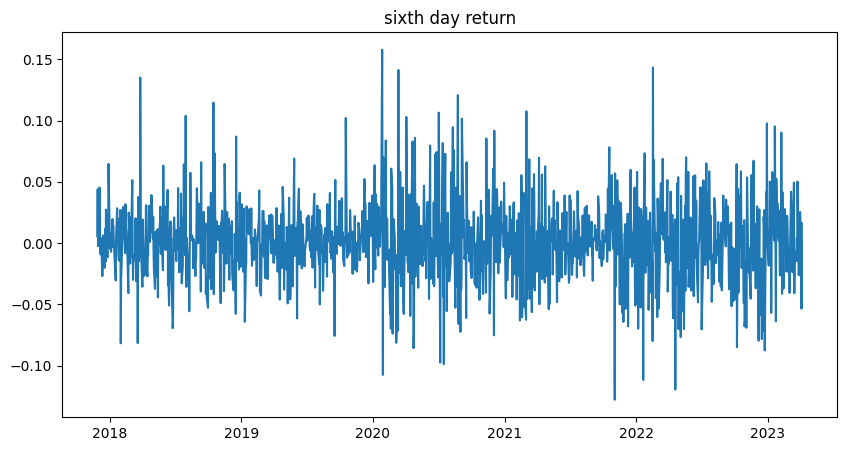

date
2017-11-28    0.005632
2017-11-29    0.043850
2017-11-30   -0.002437
2017-12-01    0.001688
2017-12-04    0.045387
2017-12-05    0.032015
2017-12-06   -0.005574
2017-12-07   -0.009149
2017-12-08    0.004122
2017-12-11   -0.017483
Name: sixth_day_return, dtype: float64


In [4]:

data['sixth_day_return'] = (
    (data['close'].shift(-5)-data['open'].shift(-5))/data['open'].shift(-5)).dropna(how='any')

# plot sixth day return
plt.figure(figsize=(10, 5))
plt.plot(data['sixth_day_return'])
plt.title('sixth day return')
plt.show()

# display the sixth day return for the first 10 days
print(data['sixth_day_return'].head(10))


### 1.2 mark golden cross point and death cross point

golden_cross    29.0
death_cross     28.0
dtype: float64


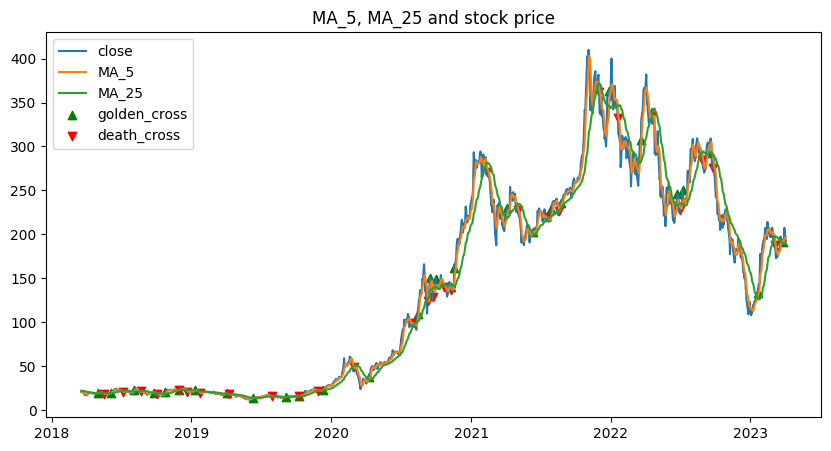

In [8]:
# calculate MA_5 and MA_25
data['MA_5'] = data['close'].rolling(5).mean()
data['MA_25'] = data['close'].rolling(25).mean()
data['diff'] = np.sign(data["MA_5"] - data["MA_25"])
data['signal'] = np.sign(data['diff'] - data['diff'].shift(1))
data['golden_cross'] = data['signal'].map({1: 1, 0: 0, -1: 0})
data['death_cross'] = data['signal'].map({-1: 1, 0: 0, 1: 0})
data = data.drop(columns=['diff', 'signal']).dropna(how='any')
print(data[['golden_cross', 'death_cross']].sum())

# move 6th day return to the last column
data = data[['open', 'close', 'high', 'low', 'daily_trading_value',
             'daily_trading_volume', 'UBB', 'BollMA', 'LBB', 'MA_5', 'MA_25', 'MACD',
             'sig_9', 'RSI_14', 'BollW', 'precent_B', 'BIAS', 'ROC_1',
             'golden_cross', 'death_cross', 'sixth_day_return']]

# plot MA_5 and MA_25 and stock price and golden cross and death cross as beautiful points, change a plot style
plt.figure(figsize=(10, 5))
plt.plot(data['close'], label='close')
plt.plot(data['MA_5'], label='MA_5')
plt.plot(data['MA_25'], label='MA_25')
plt.scatter(data[data['golden_cross'] == 1].index,
            data[data['golden_cross'] == 1]['close'], label='golden_cross', marker='^', color='green')
plt.scatter(data[data['death_cross'] == 1].index,
            data[data['death_cross'] == 1]['close'], label='death_cross', marker='v', color='red')
plt.title('MA_5, MA_25 and stock price')
plt.legend()
plt.show()


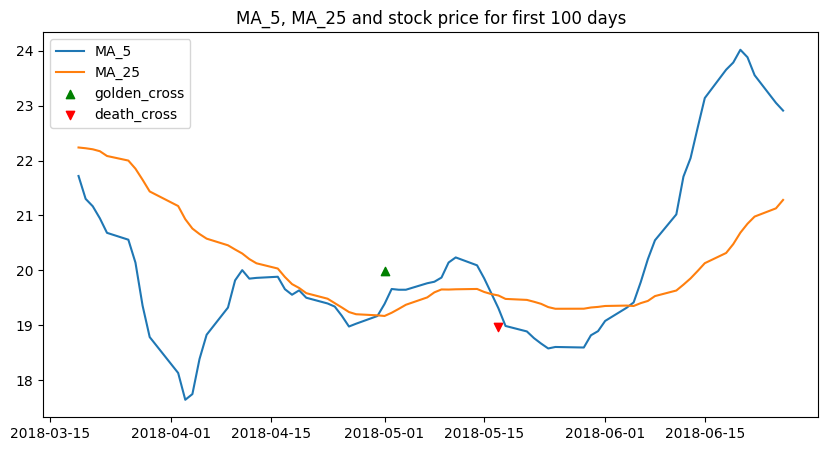

In [13]:

# plot for first 100 days
plt.figure(figsize=(10, 5))
plt.plot(data['MA_5'][:70], label='MA_5')
plt.plot(data['MA_25'][:70], label='MA_25')
plt.scatter(data[data['golden_cross'] == 1].index[0],
            data[data['golden_cross'] == 1]['close'][0], label='golden_cross', marker='^', color='green')
plt.scatter(data[data['death_cross'] == 1].index[0],
            data[data['death_cross'] == 1]['close'][0], label='death_cross', marker='v', color='red')
plt.title('MA_5, MA_25 and stock price for first 100 days')
plt.legend()
plt.show()


### 1.3 feature scaling: use normalization as extreme values are rare
Plot the distribution of the data before normalization.

Index(['open', 'close', 'high', 'low', 'daily_trading_value',
       'daily_trading_volume', 'UBB', 'BollMA', 'LBB', 'MA_5', 'MA_25', 'MACD',
       'sig_9', 'RSI_14', 'BollW ', 'precent_B', 'BIAS', 'ROC_1',
       'golden_cross', 'death_cross', 'sixth_day_return'],
      dtype='object')


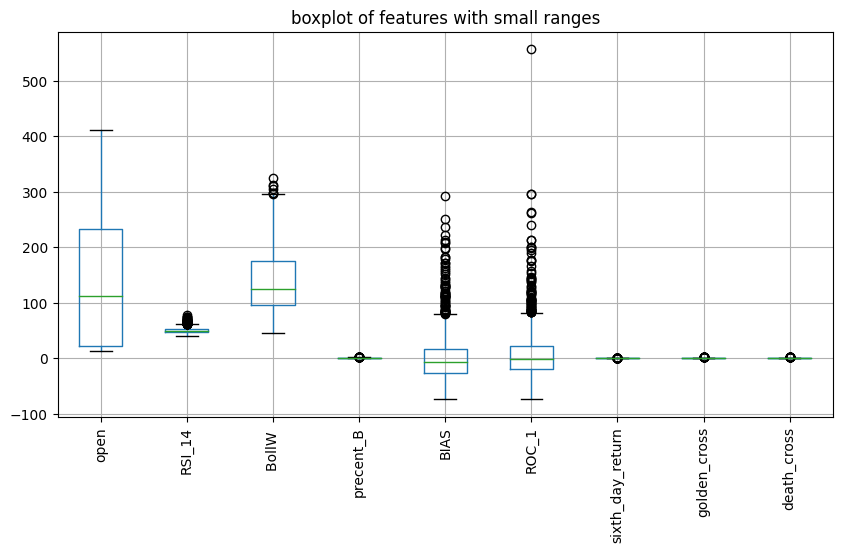

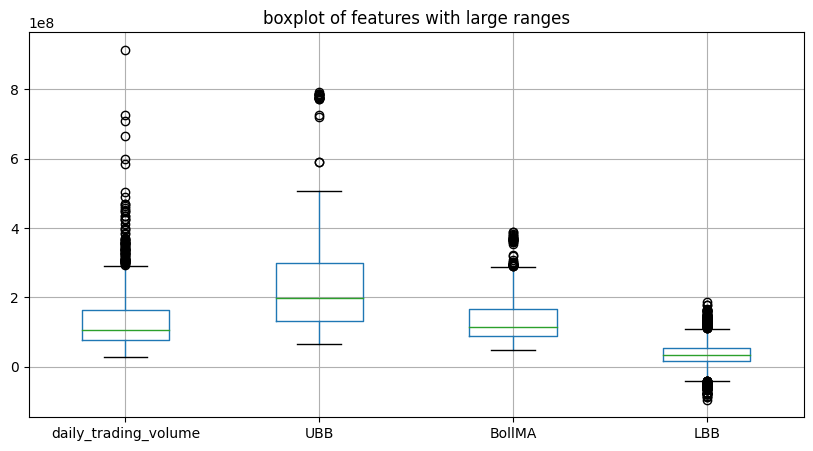

The largest range of all feature is: 150048598784.0
The smallest range of all feature is: 0.2856986744758587


In [ ]:
# print all the column names of data
print(data.columns)

# use boxplot to show the distribution of each feature except daily trading value
plt.figure(figsize=(10, 5))
data.boxplot(column=['open', 'RSI_14', 'BollW ', 'precent_B', 'BIAS', 'ROC_1',
                     'sixth_day_return', 'golden_cross', 'death_cross'])
plt.title('boxplot of features with small ranges')
# make the x-axis labels vertical
plt.xticks(rotation=90)
plt.show()

# use boxplot to show the distribution of daily trading value and feature with large range
plt.figure(figsize=(10, 5))
data.boxplot(column=['daily_trading_volume', 'UBB', 'BollMA', 'LBB'])
plt.title('boxplot of features with large ranges')
plt.show()

# print the largest range and smallest range of each feature
raw_data_range = data.max()-data.min()
print('The largest range of all feature is:', raw_data_range.max())
print('The smallest range of all feature is:', raw_data_range.min())


Perform normalization on the data.
Plot the distribution of the data after normalization.

In [ ]:
X_normalized = data.drop(['sixth_day_return'], axis=1).apply(
    lambda x: (x-x.min())/(x.max()-x.min()))
# combine the normalized data and sixth day return
data = pd.concat([X_normalized, data['sixth_day_return']], axis=1)


NameError: name 'data' is not defined

,open,close,high,low,daily_trading_value,daily_trading_volume,UBB,BollMA,LBB,MA_5,...,MACD,sig_9,RSI_14,BollW,precent_B,BIAS,ROC_1,golden_cross,death_cross,sixth_day_return
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,0.021995,0.022720,0.021866,0.021782,0.016060,0.135408,0.096850,0.109237,0.458846,0.022122,...,0.250333,0.279728,0.549433,0.271730,0.734095,0.407897,0.307338,0.0,0.0,0.475964
2018-01-05,0.022621,0.023048,0.021649,0.022852,0.004990,0.044611,0.093325,0.103499,0.454023,0.022164,...,0.242550,0.284353,0.235092,0.276694,0.260816,0.156208,0.031754,0.0,0.0,0.422764
2018-01-08,0.022517,0.026369,0.024929,0.023444,0.017123,0.133935,0.108036,0.114690,0.443214,0.023019,...,0.278845,0.298366,0.470400,0.313821,0.675625,0.399280,0.299047,0.0,0.0,0.473796
2018-01-09,0.025716,0.025914,0.025224,0.025459,0.011241,0.087939,0.109416,0.122795,0.459311,0.023468,...,0.285266,0.311401,0.338989,0.285284,0.444975,0.262914,0.073493,1.0,0.0,0.516440
2018-01-10,0.025222,0.026100,0.024926,0.025898,0.004945,0.039842,0.104806,0.114800,0.451816,0.024067,...,0.267217,0.316701,0.216528,0.294104,0.222829,0.132085,0.054185,0.0,0.0,0.436515
2018-01-11,0.025729,0.026627,0.026221,0.026450,0.010424,0.079442,0.098007,0.110200,0.458198,0.024863,...,0.271672,0.322206,0.317661,0.274340,0.432996,0.238417,0.203035,0.0,0.0,0.498599
2018-01-12,0.026295,0.026338,0.025491,0.026520,0.006163,0.048576,0.096827,0.107123,0.453779,0.025533,...,0.260386,0.323403,0.239597,0.281349,0.276581,0.157074,0.073685,0.0,0.0,0.469302
2018-01-16,0.026113,0.026981,0.026252,0.026711,0.010025,0.076539,0.097904,0.108609,0.454606,0.025658,...,0.264714,0.325591,0.312006,0.281027,0.420272,0.231820,0.171308,0.0,0.0,0.377558
2018-01-17,0.026602,0.028170,0.026915,0.027549,0.011720,0.087208,0.098348,0.108984,0.454370,0.026118,...,0.273049,0.329710,0.339521,0.281998,0.474831,0.253245,0.132527,0.0,0.0,0.361872


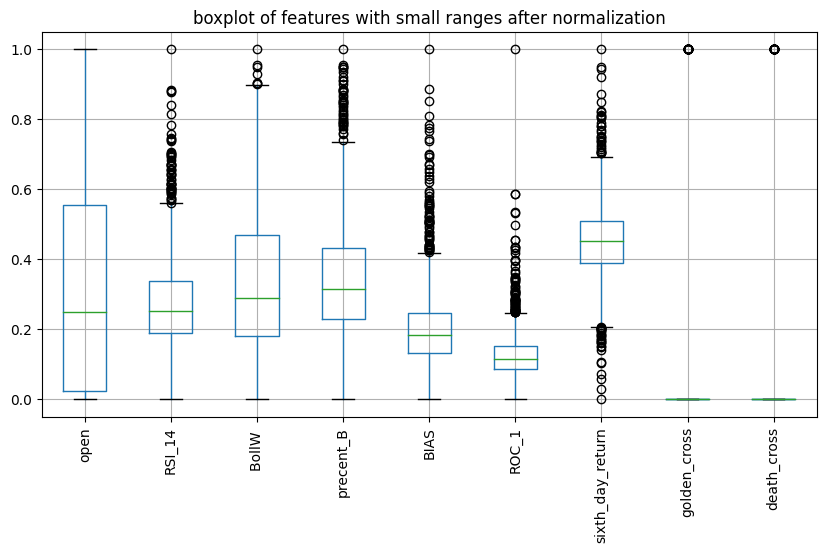

The largest range of all feature is: 1.0
The smallest range of all feature is: 1.0
There are totally 1322 days of data


In [ ]:
data = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
display(data.head(10))

# plot the distribution of each feature after normalization
plt.figure(figsize=(10, 5))
data.boxplot(column=['open', 'RSI_14', 'BollW ', 'precent_B', 'BIAS', 'ROC_1',
                     'sixth_day_return', 'golden_cross', 'death_cross'])
plt.title('boxplot of features with small ranges after normalization')
# make the x-axis labels vertical
plt.xticks(rotation=90)
plt.show()

# print the largest range and smallest range of each feature
normalized_data_range = data.max()-data.min()
print('The largest range of all feature is:', normalized_data_range.max())
print('The smallest range of all feature is:', normalized_data_range.min())
print('There are totally', len(data), 'days of data')


In [ ]:
# # plot 6th day return for the first 100 days
# plt.figure(figsize=(10, 5))
# plt.plot(data['sixth_day_return'])
# plt.title('sixth day return for the first 100 days')
# plt.show()


# # plot open price
# plt.figure(figsize=(10, 5))
# plt.plot(data['open'])
# plt.title('open price')
# plt.show()


## 2.Feature Engineering

### PCA 

## 3. Build Model

### 3.0 hyperparameter tuning

### 3.1.1 Convolutional layer & MLP 

Only use MLP

In [ ]:
# MLP define class object to fit the model in different scenarios
class MLP_TSLA:
    # def __init__(self):
    #     self.best_model = None

    # build 5-n1-n2-n3-1 MLP model
    def build_model(self, neuron_size=32):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss="mse")
        return (model)

    # train the model and try ntry times to find the best model
    def train(self, X_train, y_train, bs=32, ntry=10, neuron_size=32):
        model = self.build_model(neuron_size)
        model.fit(X_train, y_train, batch_size=bs, epochs=100, shuffle=True)

        self.best_model = model
        best_loss = model.evaluate(X_train, y_train)

        for i in range(ntry):
            model = self.build_model()
            model.fit(X_train, y_train, batch_size=bs,
                      epochs=100, shuffle=True)
            if model.evaluate(X_train, y_train) < best_loss:
                self.best_model = model
                best_loss = model.evaluate(X_train, y_train)

    # predict option price using the best model
    def predict(self, X_test):
        return (self.best_model.predict(X_test))

    # calculate mse
    def mse(self, X_test, y_test):
        return (self.best_model.evaluate(X_test, y_test))

In [ ]:
# plug in the stock data
tf.random.set_seed(4012)
# Preprocessing
X = data.drop(['sixth_day_return'], axis=1).values
y = data['sixth_day_return'].values.reshape(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
# 5-32-32-32-1
MLP1 = MLP_TSLA()
MLP1.train(X_train, y_train, bs=32, ntry=10, neuron_size=32)

Epoch 1/100
34/34 [==============================] - 2s 1ms/step - loss: 0.0258
Epoch 2/100
34/34 [==============================] - 0s 994us/step - loss: 0.0145
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 5/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7/100
34/34 [==============================] - 0s 973us/step - loss: 0.0123
Epoch 8/100
34/34 [==============================] - 0s 970us/step - loss: 0.0135
Epoch 9/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 10/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 11/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 12/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 13/100
34/34 [===========

9/9 [==============================] - 0s 1ms/step - loss: 0.0166
0.016633231192827225
9/9 [==============================] - 0s 1ms/step


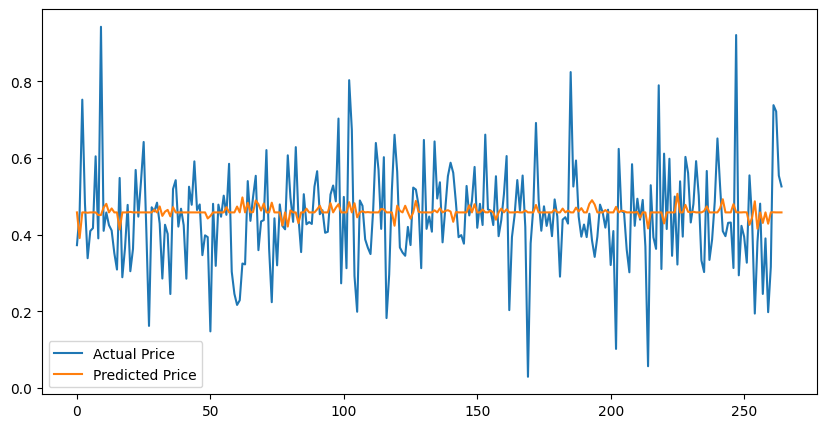

In [ ]:
# find the minimum mse loss
best_lost1 = MLP1.mse(X_test, y_test)
print(best_lost1)
y_pred1 = np.squeeze(MLP1.predict(X_test))

# plot the predicted price and actual price
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred1, label='Predicted Price')
# plt.plot((y_pred1-np.mean(y_pred1))/0.5, label='Predicted Price scaled')
plt.legend()
plt.show()


In [ ]:
# 5-64-64-64-1
MLP2 = MLP_TSLA()
MLP2.train(X_train, y_train, bs=32, ntry=10, neuron_size=64)


Epoch 1/100
34/34 [==============================] - 1s 1ms/step - loss: 0.0231
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 10/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 11/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 13/100
34/34 [=================

9/9 [==============================] - 0s 2ms/step - loss: 0.0165
0.01647292450070381
9/9 [==============================] - 0s 982us/step


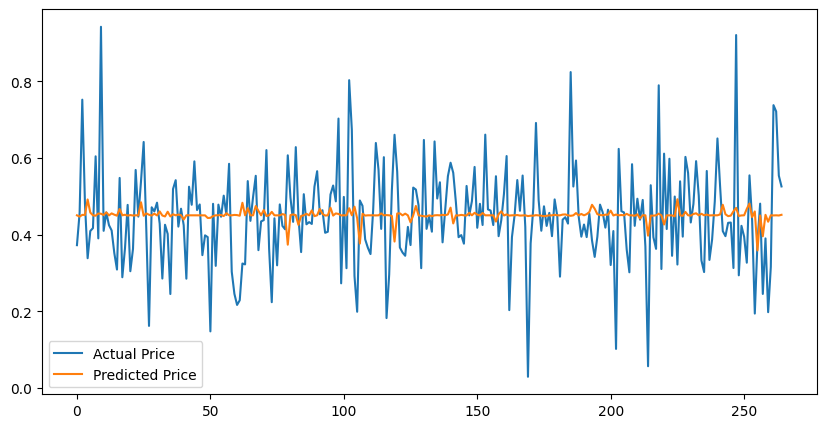

In [ ]:
best_lost2 = MLP2.mse(X_test, y_test)
print(best_lost2)
y_pred2 = np.squeeze(MLP2.predict(X_test))
# plot the y_test with y_pred2 in the same plot to see the prediction result
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred2, label='Predicted Price')
plt.legend()
plt.show()

In [ ]:
# 5-128-128-129-1
MLP3 = MLP_TSLA()
MLP3.train(X_train, y_train, bs=32, ntry=10, neuron_size=128)


Epoch 1/100
34/34 [==============================] - 1s 2ms/step - loss: 0.2152
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.2152
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 0.2152
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 0.2152
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 13/100
34/34 [=================

9/9 [==============================] - 0s 1ms/step - loss: 0.0164
0.016383370384573936
9/9 [==============================] - 0s 1ms/step


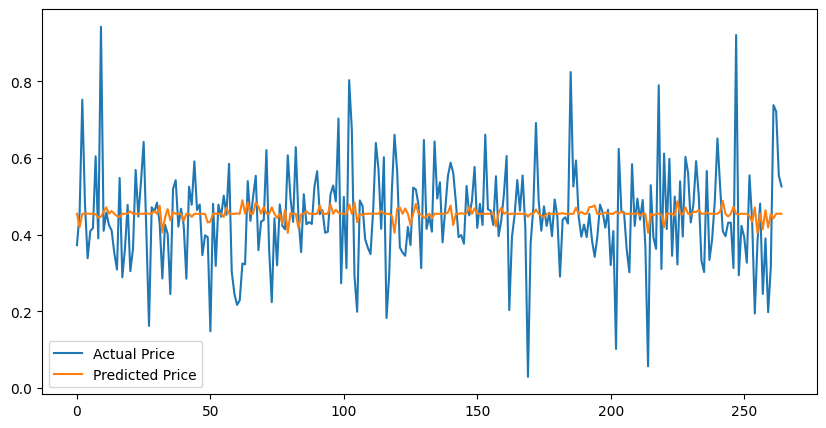

In [ ]:
best_lost3 = MLP3.mse(X_test, y_test)
print(best_lost3)
y_pred3 = np.squeeze(MLP3.predict(X_test))
# plot the y_test with y_pred2 in the same plot to see the prediction result
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred3, label='Predicted Price')
plt.legend()
plt.show()

Put MLP and CNN together

In [ ]:
class CNN_MLP_TSLA:
    def build_model(self, neuron_size=32):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                  activation='relu', input_shape=X_train.shape[1:]))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        # model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
        # model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        # tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(neuron_size, activation='relu'))
        # model.add(tf.keras.layers.Dense(neuron_size, activation='relu'))
        # model.add(tf.keras.layers.Dense(neuron_size, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='relu'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss='mse')
        return (model)

    def train(self, X_train, y_train, bs=32, ntry=10, neuron_size=32):
        model = self.build_model(neuron_size)
        model.fit(X_train, y_train, batch_size=bs, epochs=100, shuffle=True)

        self.best_model = model
        best_loss = model.evaluate(X_train, y_train)

        for i in range(ntry):
            model = self.build_model()
            model.fit(X_train, y_train, batch_size=bs,
                      epochs=100, shuffle=True)
            if model.evaluate(X_train, y_train) < best_loss:
                self.best_model = model
                best_loss = model.evaluate(X_train, y_train)


    def predict(self, X_test):
        return (self.best_model.predict(X_test))
    
    def mse(self, X_test, y_test):
        return (self.best_model.evaluate(X_test, y_test))



In [ ]:
# Reshape the input data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# predit the stock price
CNN_MLP = CNN_MLP_TSLA()
CNN_MLP.train(X_train, y_train, bs=32, ntry=10, neuron_size=16)


Epoch 1/100
34/34 [==============================] - 1s 2ms/step - loss: 0.0269
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 13/100
34/34 [=================

9/9 [==============================] - 0s 3ms/step - loss: 0.0164
0.016404761001467705


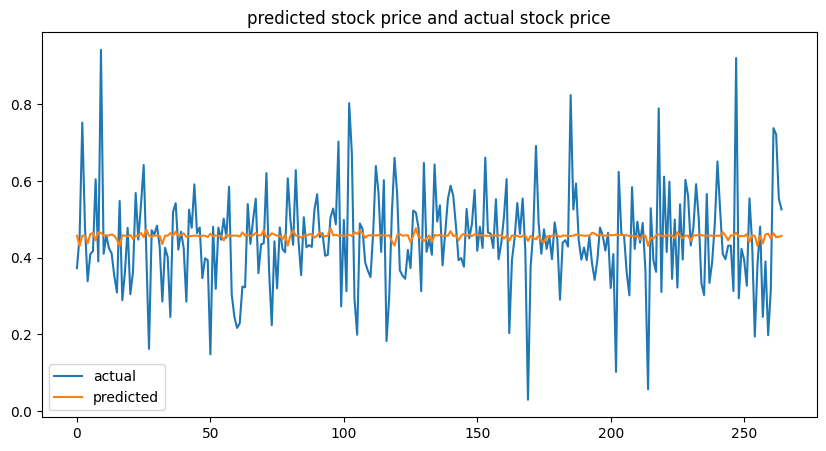

In [ ]:
y_pred = np.squeeze(CNN_MLP.predict(X_test))
print(CNN_MLP.mse(X_test, y_test))

# calculate std and mean of y pred
std = np.std(y_pred)
# print(std)
mean = np.mean(y_pred)

# anti standardization
y_pred_scale = (y_pred-mean+0.035)/0.08

# plot predict and true
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
# plt.plot(y_pred_scale, label='predicted scaled')
plt.title('predicted stock price and actual stock price')
plt.legend()
plt.show()



MLP for just one features

In [ ]:
class MLP_One_Feature:
    # def __init__(self):
    #     self.best_model = None

    # build 5-n1-n2-n3-1 MLP model
    def build_model(self, neuron_size=32):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(neuron_size, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss="mse")
        return (model)

    # train the model and try ntry times to find the best model
    def train(self, X_train, y_train, bs=32, ntry=10, neuron_size=32):
        model = self.build_model(neuron_size)
        model.fit(X_train, y_train, batch_size=bs, epochs=100, shuffle=True)

        self.best_model = model
        best_loss = model.evaluate(X_train, y_train)

        for i in range(ntry):
            model = self.build_model()
            model.fit(X_train, y_train, batch_size=bs,
                      epochs=100, shuffle=True)
            if model.evaluate(X_train, y_train) < best_loss:
                self.best_model = model
                best_loss = model.evaluate(X_train, y_train)

    # predict option price using the best model
    def predict(self, X_test):
        return (self.best_model.predict(X_test))

    # calculate mse
    def mse(self, X_test, y_test):
        return (self.best_model.evaluate(X_test, y_test))

In [ ]:
# 5-32-32-32-1
MLP4 = MLP_One_Feature()

# let X_train_one be the first column in X_train
X_train_one = X_train[:, 0].reshape(-1, 1)
X_test_one = X_test[:, 0].reshape(-1, 1)


In [ ]:
MLP4.train(X_train_one, y_train, bs=32, ntry=10, neuron_size=32)


Epoch 1/100
34/34 [==============================] - 3s 6ms/step - loss: 0.2152
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2152
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2152
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2152
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2152
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.2152
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2152
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 13/100
34/34 [=================

9/9 [==============================] - 0s 1ms/step - loss: 0.0164
0.016413483768701553
9/9 [==============================] - 0s 1ms/step


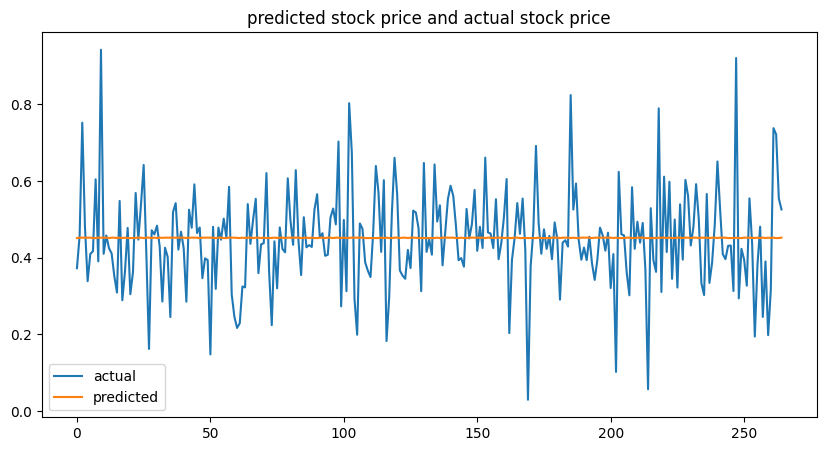

In [ ]:
best_lost4 = MLP4.mse(X_test_one, y_test)
print(best_lost4)
y_pred4 = np.squeeze(MLP4.predict(X_test_one))

# plot
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='actual')
plt.plot(y_pred4, label='predicted')
plt.title('predicted stock price and actual stock price')
plt.legend()
plt.show()


###### test code for CNN
New code after accuracy = 0

In [ ]:
x = np.array([data[k: k+5-1].values for k in range(1000)])
x = x[:, :, 0:20]
x.shape


(1000, 4, 20)

In [ ]:
y = np.array(data['sixth_day_return'][5:1005])
y.shape


(1000,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=4012)


In [ ]:
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(4, 20)))
model.add(MaxPooling1D(2))
# model.add(Conv1D(64, 4, padding='same'))
# model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_427"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_187 (Conv1D)         (None, 3, 32)             1312      
                                                                 
 max_pooling1d_172 (MaxPooli  (None, 1, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_150 (Flatten)       (None, 32)                0         
                                                                 
 dense_1407 (Dense)          (None, 32)                1056      
                                                                 
 dense_1408 (Dense)          (None, 16)                528       
                                                                 
 dense_1409 (Dense)          (None, 1)                 17        
                                                    

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
25/25 [==============================] - 1s 2ms/step - loss: 0.6898 - accuracy: 0.0012 
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.0012
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.0012
Epoch 4/10
25/25 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.0012
Epoch 5/10
25/25 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.0012
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.0012
Epoch 7/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.0012
Epoch 8/10
25/25 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.0012
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.0012
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.0012


7/7 [==============================] - 0s 2ms/step


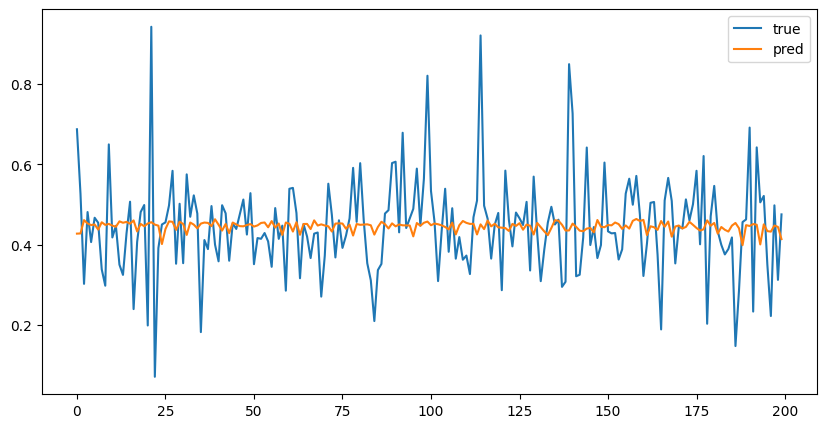

In [ ]:
y_pred = model.predict(X_test)
# plot
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()


Code original from lxl

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [ ]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X, y = split_sequences(data.to_numpy(), n_steps)
print(X.shape, y.shape)


(1318, 5, 20) (1318,)


In [ ]:
# split for training set and testing set
X_train, X_test = X[:1000, :, :], X[1000:, :, :]
y_train, y_test = y[:1000], y[1000:]
np.savetxt('y_test.csv', y_test, delimiter=',')


In [ ]:
# define model
n_features = X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
          input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


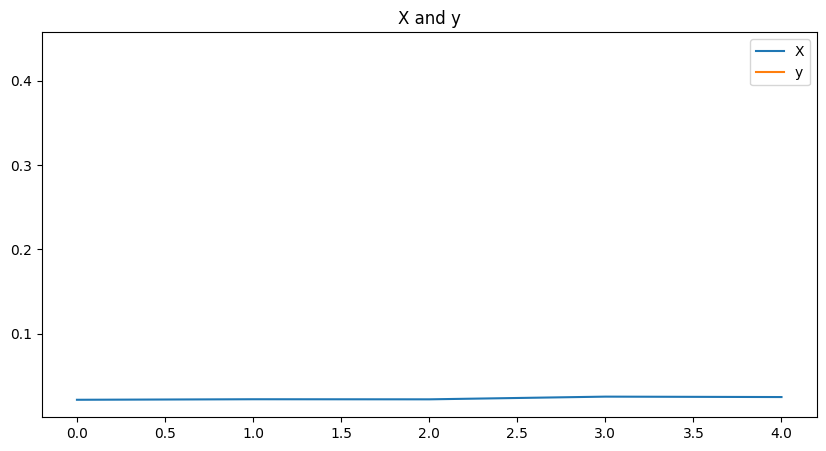

In [ ]:
# plot X_train and y
plt.figure(figsize=(10, 5))
plt.plot(X[0, :, 0], label='X')
plt.plot(y[0], label='y')
plt.title('X and y')
plt.legend()
plt.show()


In [ ]:
# fit model


print(X_train.shape, y_train.shape)
model.fit(X_train, y_train, epochs=1000, verbose=1)


(1000, 5, 20) (1000,)
Epoch 1/1000
32/32 [==============================] - 1s 2ms/step - loss: 0.0465
Epoch 2/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 6/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 7/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 9/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 10/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 11/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0115
Epo

10/10 [==============================] - 0s 3ms/step
(318, 1)


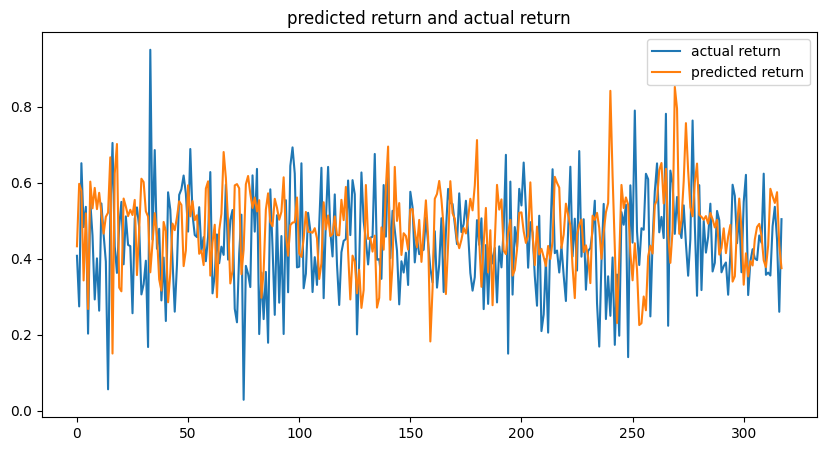

In [ ]:
# demonstrate prediction
y_pred = model.predict(X_test, verbose=1)
print(y_pred.shape)

# plot the predicted return and the actual return
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='actual return')
plt.plot(y_pred, label='predicted return')
plt.title('predicted return and actual return')
plt.legend()
plt.show()


In [ ]:
from keras import losses
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])
model.evaluate(X_test, y_test)


10/10 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.0000e+00


[0.029968123883008957, 0.0]

Define functions.

In [ ]:
# Define reshape function to reshape the data into 3D array for CNN.
# split a 1322 * 21 matrix into (1322-n_days+1)/stride * n_days * 20 tensorflow matrix
def data_reshape(sequences, n_days=5, stride=1):
    X, y = list(), list()
    for i in range(0, len(sequences), stride):
        # find the last day of each tensor
        end_ix = i + n_days
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)

        # display first 5 samples in a pandas dataframe for better visualization
        if i < 5:
            print('X=%s, y=%s' % (seq_x, seq_y))

    return array(X), array(y)


In [ ]:
# define CNN model
def define_model(n_steps, n_features, n_filters=64, n_kernel=2):
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
# define split data into train and test sets function
def split_data(data, n_days=5, stride=1):
    # reshape into (1322-n_days+1)/stride * n_days * 20 tensorflow matrix
    X, y = data_reshape(data.to_numpy(), n_days, stride)
    # print(X.shape, y.shape)

    # split into train and test sets with 80% and 20% of data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4012)
    return X_train, X_test, y_train, y_test


In [ ]:

X_train, X_test, y_train, y_test = split_data(data, n_days=5, stride=1)

# summarize the data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


X=[[0.02199492 0.0227199  0.02186636 0.02178196 0.01605957 0.1354082
  0.09685027 0.10923706 0.45884611 0.02212194 0.02163601 0.25033295
  0.27972771 0.54943297 0.27173027 0.73409472 0.40789731 0.30733821
  0.         0.        ]
 [0.02262087 0.02304801 0.02164897 0.02285161 0.0049905  0.04461052
  0.09332543 0.10349873 0.45402306 0.02216356 0.02170326 0.2425504
  0.28435252 0.2350923  0.27669397 0.26081559 0.15620753 0.03175408
  0.         0.        ]
 [0.02251746 0.0263693  0.0249289  0.02344394 0.01712322 0.13393531
  0.10803641 0.11469006 0.44321427 0.02301878 0.0219083  0.27884468
  0.29836577 0.47040031 0.31382136 0.67562535 0.39927999 0.29904708
  0.         0.        ]
 [0.02571554 0.02591381 0.02522414 0.02545909 0.0112413  0.08793894
  0.10941581 0.12279498 0.45931077 0.02346789 0.02211038 0.28526646
  0.31140119 0.3389891  0.2852842  0.44497548 0.26291373 0.07349275
  1.         0.        ]
 [0.02522154 0.02609972 0.02492567 0.02589832 0.00494477 0.03984178
  0.10480568 0.1

In [ ]:
# fit model
model = define_model(n_steps=5, n_features=20)
model.fit(X_train, y_train, epochs=1000, verbose=1)


Epoch 1/1000
33/33 [==============================] - 1s 3ms/step - loss: 0.0396
Epoch 2/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 13/1000
33/33 [====

9/9 [==============================] - 0s 1ms/step - loss: 0.0403
0.04029189050197601


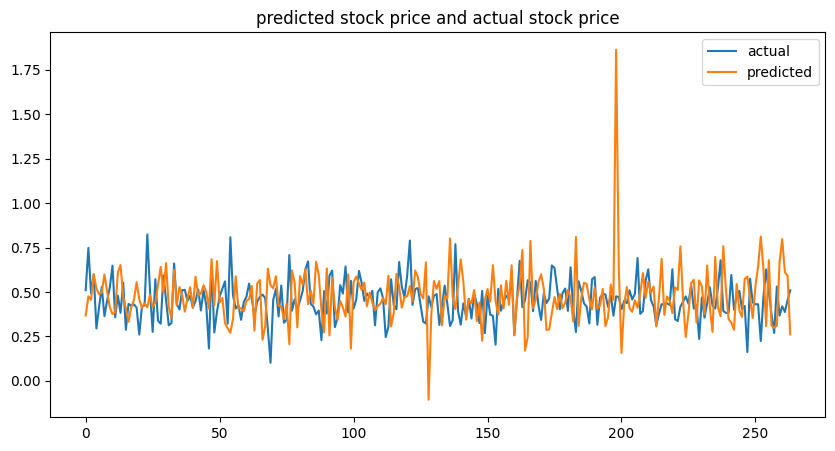

In [ ]:
# demonstrate prediction
y_pred = model.predict(X_test, verbose=1)
print(model.evaluate(X_test, y_test))

# plot the predicted stock price and actual stock price
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.title('predicted stock price and actual stock price')
plt.legend()
plt.show()


##### Model evaluation

In [ ]:
from keras import losses
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.evaluate(X_test, y_test)


9/9 [==============================] - 0s 2ms/step - loss: 5.4000e-08 - accuracy: 0.0000e+00


c:\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


[5.4000295790501696e-08, 0.0]

CNN Model by ChatGPT

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Preprocessing
X = data.drop(['sixth_day_return'], axis=1).values
y = data['sixth_day_return'].values.reshape(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define reshape function to reshape the data into 3D array for CNN.
# split a 1322 * 21 matrix into (1322-n_days+1)/stride * n_days * 20 tensorflow matrix


def data_reshape(sequences, n_days=5, stride=1):
    X, y = list(), list()
    for i in range(0, len(sequences), stride):
        # find the last day of each tensor
        end_ix = i + n_days
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)

# define CNN model


def define_model(n_steps, n_features, n_filters=128, n_kernel=2, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# define split data into train and test sets function


def split_data(data, n_days=5, stride=1):
    # reshape into (1322-n_days+1)/stride * n_days * 20 tensorflow matrix
    X, y = data_reshape(data.to_numpy(), n_days, stride)

    # split into train and test sets with 80% and 20% of data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4012)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(data, n_days=5, stride=1)

# summarize the data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# define learning rate scheduler callback


def lr_scheduler(epoch):
    if epoch < 200:
        return 0.001
    elif epoch < 400:
        return 0.0001
    else:
        return 0.00001


lr_schedule = LearningRateScheduler(lr_scheduler)

# fit model
model = define_model(n_steps=5, n_features=20, n_filters=128, dropout_rate=0.3)
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stop, lr_schedule])


(1054, 5, 20) (1054,) (264, 5, 20) (264,)


ValueError: Exception encountered when calling layer "max_pooling1d_176" (type MaxPooling1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d_176/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d_176/ExpandDims)' with input shapes: [?,1,1,128].

Call arguments received by layer "max_pooling1d_176" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 1, 128), dtype=float32)

Only one feature using MLP

### 3.2 Attention-based LSTM model （实验组）
structure: data -> LSTM layer -> Attention layer -> Dense layer -> prediction

In [ ]:
from attention import Attention
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model


In [ ]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Attention(units=32)(x)
x = Dense(1)(x)
Attention_model = Model(model_input, x)
Attention_model.compile(loss='mae', optimizer='adam')
Attention_model.summary()


In [ ]:
# train.
Attention_model.fit(X_train, y_train, epochs=10)


In [ ]:
Attention_model.compile(loss='categorical_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])
Attention_model.evaluate(X_test, y_test)


### 3.3 Simple LSTM （对照组1）

In [ ]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Dense(1)(x)
LSTM_model = Model(model_input, x)
LSTM_model.compile(loss='mae', optimizer='adam')
LSTM_model.summary()


In [ ]:
# train.
LSTM_model.fit(X_train, y_train, epochs=10)


In [ ]:
LSTM_model.compile(loss='categorical_crossentropy',
                   optimizer='sgd',
                   metrics=['accuracy'])


需要evaluations

### 3.4 ARIMA model（对照组2）

In [ ]:
y_train = data['sixth_day_return'].iloc[:1000]
y_test = data['sixth_day_return'].iloc[1000:]


In [ ]:
# check stationary
plt.plot(y_train)   # looks good


In [ ]:
# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print(result)  # p-value = 2e-30 -> stationary


In [ ]:
from pmdarima.arima import auto_arima

model = auto_arima(y_train, trace=True,
                   error_action='ignore', suppress_warnings=True)
print(model.aic())


In [ ]:
model.fit(y_train)

y_pred = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(
    y_pred.values, index=y_test.index, columns=['Prediction'])
print(forecast)


In [ ]:
# plot the predictions for validation set
plt.plot(y_train, label='Train', color='blue')
plt.plot(y_test, label='Valid', color='black')
plt.plot(forecast, label='Prediction', color='red')
plt.show()


In [ ]:
# evaluate the model


## 4. Model Evaluation

### 4.1 MSE, scores
### 4.2 Back-testing

In [ ]:
import backtrader as bt
import datetime


class Backtest(bt.Strategy):
    params = (("printlog", True), ("quantity", 20000))

    def log(self, txt, dt=None, doprint=False):
        """Logging function for strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.dataopen = self.datas[0].open
        self.dataclose = self.datas[0].close
        self.order = 0
        self.open = 1

    def next(self):

        if self.order == 1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1

        if self.order == -1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1


if __name__ == "__main__":

    # Read data
    newdata = data.reset_index()
    array1 = np.repeat(newdata.values, 2, axis=0)
    for i in range(len(newdata.index)):
        array1[2*i+1][0] += datetime.timedelta(hours=14)
    newdata = pd.DataFrame(array1)
    newdata.columns = data.reset_index().columns
    newdata.set_index('date')
    newdata = newdata[['open', 'close', 'sixth_day_return']]
    newdata.head()

    # Add our strategy
    cerebro = bt.Cerebro()
    cerebro.addstrategy(IntraDayStrategy)

    # Add data
    data1 = bt.feeds.PandasData(dataname=newdata['2021-11-17':'2023-04-08'])
    cerebro.adddata(data1)

    # Run the strategy
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                        riskfreerate=0.03, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
    result = cerebro.run()
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    strat = result[0]

    # Analysis
    print("--------------- AnnualReturn -----------------")
    print(strat.analyzers.AnnualReturn.get_analysis())
    print("--------------- SharpeRatio -----------------")
    print(strat.analyzers.SharpeRatio.get_analysis())
    print("--------------- DrawDown -----------------")
    print(strat.analyzers.DrawDown.get_analysis())
    cerebro.plot()
